# Zadanie 02

## Kwadraty bez trójkątów (za to z wysokim stężeniem konwolucji)

#### Required imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
plt.rcParams['figure.figsize'] = [16, 9]

#### Loading input image

(600, 976, 3)


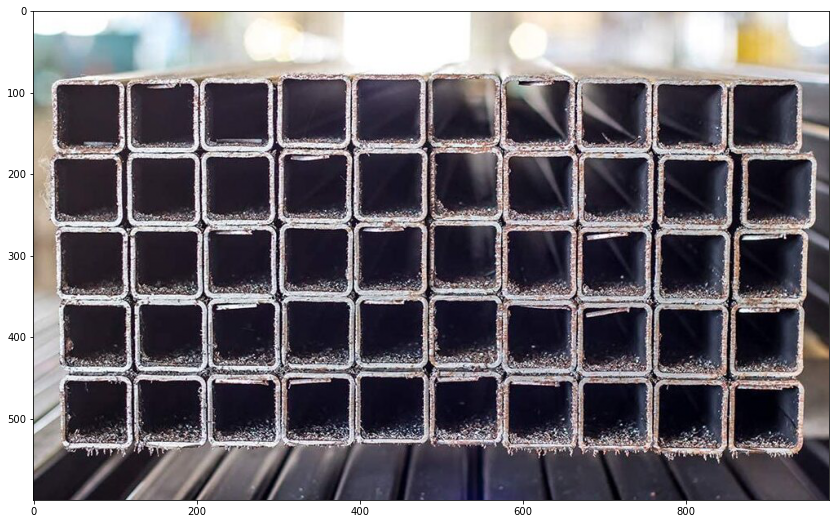

In [2]:
pipes_image = image.imread('./pipes.jpg')/255.0
print(pipes_image.shape)
plt.imshow(pipes_image, cmap='gray')

#### Converting image to one-element-batch tensor

In [3]:
pipes_image_tensor = tf.expand_dims(pipes_image, 0) # to create 1-element batch, to match tensor shape for layers
print(pipes_image_tensor.shape)

(1, 600, 976, 3)


### First layer - RGB to grayscale

#### Creating first layer

In [4]:
rgb_weights = [[0.299], [0.587], [0.114]] # weigths of RGB channels
weights = np.zeros([1, 1, 3, 1])
weights[0, 0] = rgb_weights
weights = [weights]
rgb_to_bw = tf.keras.layers.Conv2D(
    filters = 1, # number of output filters in convolution, 
    kernel_size = (1, 1), # list/tuple of 2 integers, height and width of 2D conv window,
    strides = (1, 1), # list/tuple of 2 integers, specyfying strides along height and width,
    padding = 'same', # 'valid' - no padding, 'same' output has the same dimensions as the input,
    data_format = 'channels_last', # info that number of channels is the last one in input_shape
    input_shape = pipes_image.shape[1:],
    use_bias = False,
    weights = weights
)

#### First layer - output

(600, 976, 1)


TypeError: Invalid shape (600, 976, 1) for image data

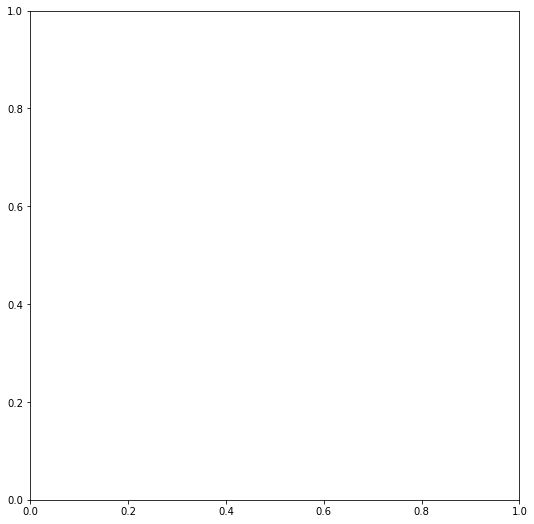

In [5]:
gray_pipes_tensor = rgb_to_bw(pipes_image_tensor)
gray_pipes = gray_pipes_tensor[0]
print(gray_pipes.shape)
plt.imshow(gray_pipes, cmap='gray')

### Second layer - gaussian blur

#### Gaussian kernel generator "borrowed" from: https://stackoverflow.com/a/43346070

In [7]:
def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

#### Small generator test :)

In [8]:
print(gkern(3, 0.5))
print(np.sum(gkern(3, 0.5)))

[[0.01134374 0.08381951 0.01134374]
 [0.08381951 0.61934703 0.08381951]
 [0.01134374 0.08381951 0.01134374]]
1.0


#### Creating second layer

In [9]:
n = 5 # size of the kernel
std = 8 # standard deviation - gaussian distribution parameter
weights_gauss = gkern(n, std)  
weights = np.zeros([n, n, 1, 1])
weights[:, :, 0, 0] = weights_gauss
weights = [weights]
blurr = tf.keras.layers.Conv2D(
    filters = 1, # number of output filters in convolution, 
    kernel_size = (n, n), # list/tuple of 2 integers, height and width of 2D conv window,
    strides = (1, 1), # list/tuple of 2 integers, specyfying strides along height and width,
    padding = 'same', # 'valid' - no padding, 'same' output has the same dimensions as the input,
    data_format = 'channels_last', # info that number of channels is the last one in input_shape
    input_shape = gray_pipes_tensor.shape[1:],
    use_bias=False,
    weights = weights
)

#### Second layer - output

(600, 976, 1)


TypeError: Invalid shape (600, 976, 1) for image data

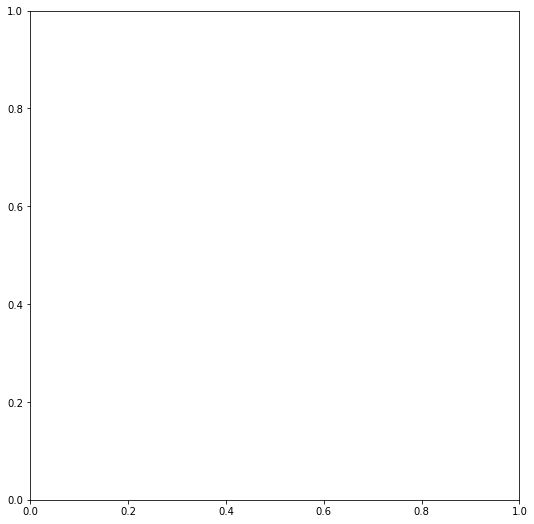

In [10]:
blurred_pipes_tensor = blurr(gray_pipes_tensor)
blurred_pipes = blurred_pipes_tensor[0]
print(blurred_pipes.shape)
plt.imshow(blurred_pipes, cmap='gray')

### Third layer - gradient calculation

#### Sobel filters

In [11]:
vertical_sobel = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])
horizontal_sobel = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
])

#### Creating third layer

In [12]:
weights = np.zeros([3, 3, 1, 2])
weights[:, :, 0, 0] = vertical_sobel
weights[:, :, 0, 1] = horizontal_sobel
weights = [weights]
sobel = tf.keras.layers.Conv2D(
    filters = 2, # number of output filters in convolution, 
    kernel_size = 3, # list/tuple of 2 integers, height and width of 2D conv window,
    strides = (1, 1), # list/tuple of 2 integers, specyfying strides along height and width,
    padding = 'same', # 'valid' - no padding, 'same' output has the same dimensions as the input,
    data_format = 'channels_last', # info that number of channels is the last one in input_shape
    input_shape = blurred_pipes_tensor.shape[1:],
    use_bias=False,
    weights = weights
)

#### Third layer - output - first channel

(600, 976)


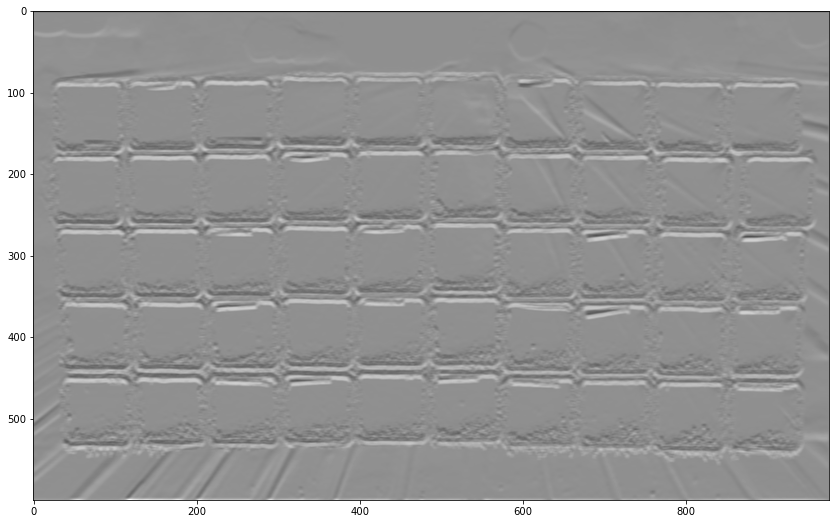

In [13]:
sobel_pipes_tensor = sobel(blurred_pipes_tensor)
sobel_pipes_v = sobel_pipes_tensor[0, :, :, 0]
sobel_pipes_h = sobel_pipes_tensor[0, :, :, 1]
print(sobel_pipes_v.shape)
plt.imshow(sobel_pipes_v, cmap='gray')

#### Third layer - output - second channel

(600, 976)


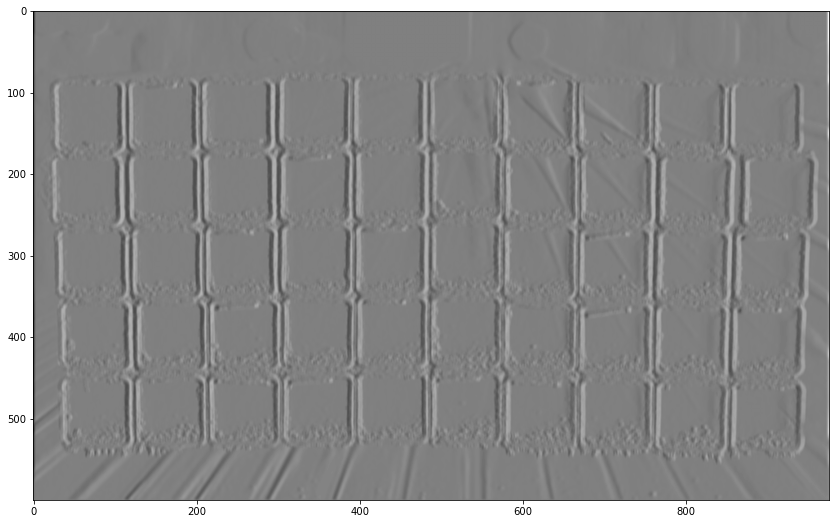

In [14]:
print(sobel_pipes_h.shape)
plt.imshow(sobel_pipes_h, cmap='gray')

#### Calculating the lenght of gradient vector

In [15]:
sobel_pipes_h = tf.math.square(sobel_pipes_h)
sobel_pipes_v = tf.math.square(sobel_pipes_v)

sobel_pipes = tf.math.add(sobel_pipes_h, sobel_pipes_v)

sobel_pipes = tf.math.sqrt(sobel_pipes)

sobel_pipes = sobel_pipes/np.max(sobel_pipes)

#### Gradient image

(600, 976)


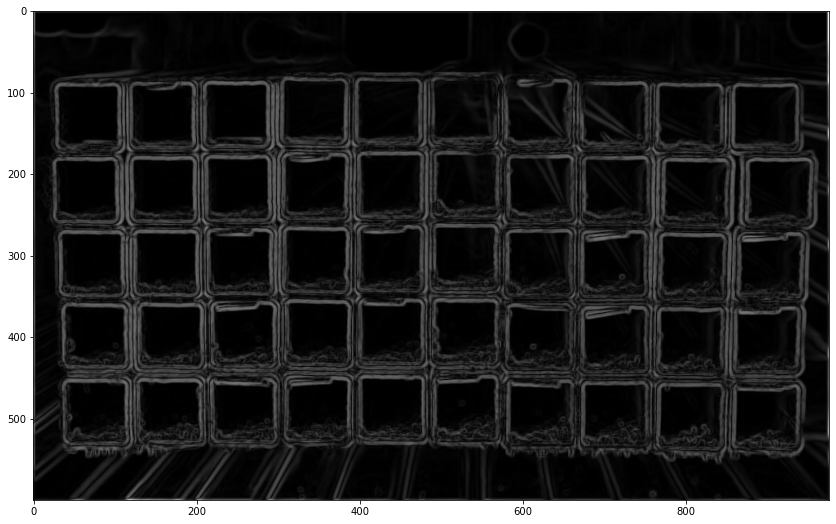

In [16]:
print(sobel_pipes.shape)
plt.imshow(sobel_pipes, cmap='gray')

### Fourth layer - treshold filtering

#### Converting image to one-element-batch tensor

In [17]:
sobel_pipes_tensor = tf.reshape(sobel_pipes, [1, 600, 976, 1])

#### Creating fourth layer

In [18]:
relu = tf.keras.layers.ReLU(
    threshold=.2,
    input_shape = sobel_pipes_tensor.shape[1:]
)
sobel_pipes_tensor.shape

TensorShape([1, 600, 976, 1])

#### Fourth layer - output

(600, 976, 1)


TypeError: Invalid shape (600, 976, 1) for image data

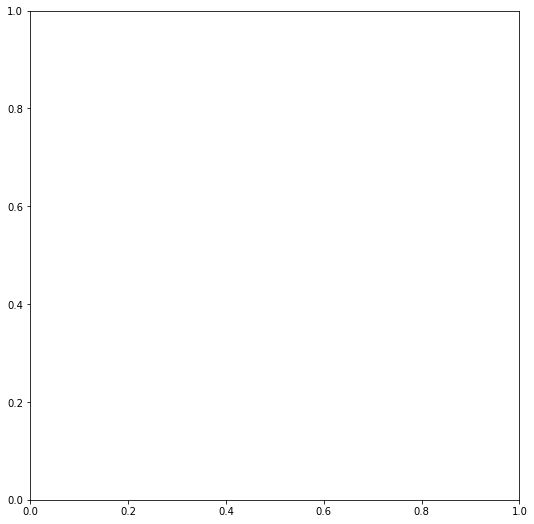

In [19]:
relud_pipes_tensor = relu(sobel_pipes_tensor)
relud_pipes = relud_pipes_tensor[0]
print(relud_pipes.shape)
plt.imshow(relud_pipes, cmap='gray')

### Fifth layer - pooling

#### Creating fifth layer

In [20]:
poooling = tf.keras.layers.AveragePooling2D(
    pool_size = (8, 8),
    strides = None,
    padding = 'valid'
)

#### Fifth layer - output

(75, 122, 1)


TypeError: Invalid shape (75, 122, 1) for image data

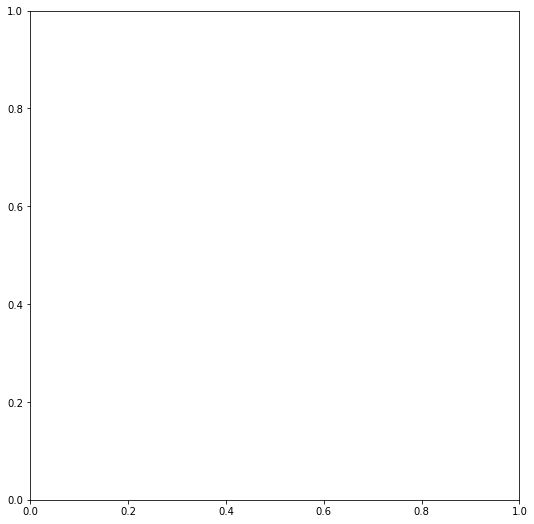

In [21]:
pooled_pipes_tensor = poooling(relud_pipes_tensor)
pooled_pipes = pooled_pipes_tensor[0]
print(pooled_pipes.shape)
plt.imshow(pooled_pipes, cmap='gray')

### Sixth layer - transposed convolution

#### Method used to generate kernels for Hough transform

In [22]:
def gen_hough_kernel(inner_l=3, outer_l=15):
    a = np.zeros(shape=(outer_l, outer_l))
    d = (outer_l-inner_l)//2
    a[d, d:(outer_l-d)] = 1
    a[d:(outer_l-d), d] = 1
    a[-d-1, d:(outer_l-d)] = 1
    a[d:(outer_l-d), -d-1] = 1
    return a

#### Example usage

In [23]:
gen_hough_kernel(4)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

#### Creating sixth layer

In [24]:
n = 15
filters = 6
weights = np.zeros([n, n, filters, 1])
for number, size in enumerate([i for i in range(5, 17, 2)]):
    weights[:, :, number] = np.reshape(gen_hough_kernel(inner_l=size, outer_l=n), [n, n, 1])
weights = [weights]
hough = tf.keras.layers.Conv2DTranspose(
    filters = filters, # number of output filters in convolution, 
    kernel_size = (n, n), # list/tuple of 2 integers, height and width of 2D conv window,
    strides = (1, 1), # list/tuple of 2 integers, specyfying strides along height and width,
    padding = 'same', # 'valid' - no padding, 'same' output has the same dimensions as the input,
    data_format = 'channels_last', # info that number of channels is the last one in input_shape
    input_shape = pooled_pipes_tensor.shape[1:],
    use_bias=False,
    weights = weights
)

#### Sixth layer - output - first channel

(1, 75, 122, 6)
(75, 122)


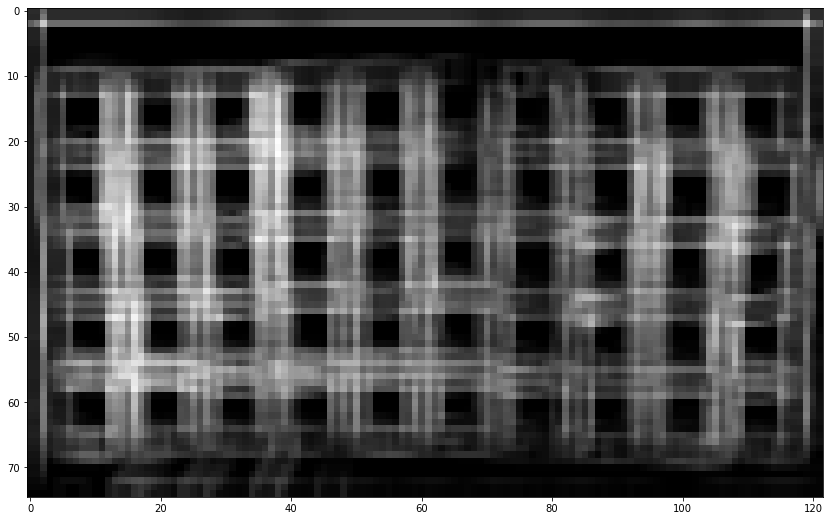

In [25]:
hough_pipes_tensor = hough(pooled_pipes_tensor)
print(hough_pipes_tensor.shape)
hough_pipes = hough_pipes_tensor[0, :, :, 0]
print(hough_pipes.shape)
plt.imshow(hough_pipes, cmap='gray')

#### Normalizing values in all channels

In [26]:
hough_pipes_tensor_normalized = np.zeros(hough_pipes_tensor.shape)
for i in range(filters):
    hough_pipes_tensor_normalized[0, :, :, i] = hough_pipes_tensor[0, :, :, i]/np.max(hough_pipes_tensor[0, :, :, i])
hough_pipes_tensor_normalized = tf.convert_to_tensor(hough_pipes_tensor_normalized)

#### Sixth layer - output - all channels

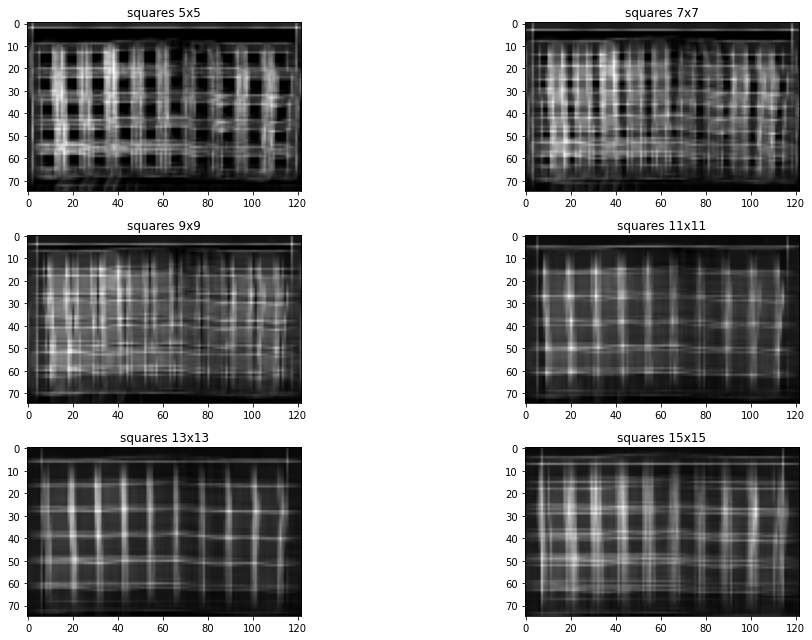

In [27]:
for i in range(filters):
    plt.subplot(3,2,i+1)
    plt.title("squares {size}x{size}".format(size=5+i*2))
    plt.imshow(hough_pipes_tensor_normalized[0, :, :, i], cmap='gray')
plt.tight_layout()
plt.show()

### Seventh layer - treshold filtering

#### Creating seventh layer

In [28]:
relu_hough = tf.keras.layers.ReLU(
    threshold=0.75,
    input_shape = hough_pipes_tensor_normalized.shape[1:]
)

In [29]:
relud_hough_pipes_tensor = relu_hough(hough_pipes_tensor_normalized)

#### Seventh layer - output - all channels

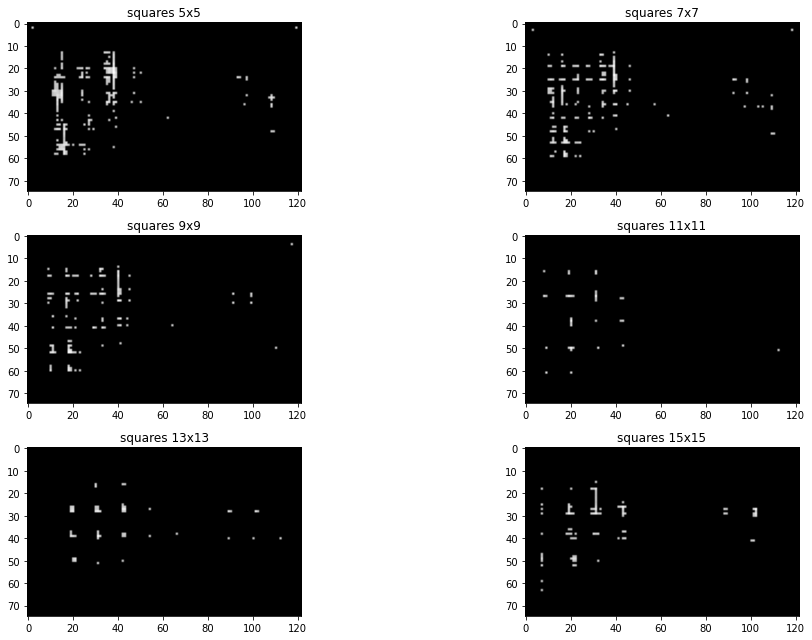

In [30]:
for i in range(filters):
    plt.subplot(3,2,i+1)
    plt.title("squares {size}x{size}".format(size=5+i*2))
    plt.imshow(relud_hough_pipes_tensor[0, :, :, i], cmap='gray')
plt.tight_layout()
plt.show()

### Eighth layer

#### Creating eighth layer

In [31]:
n = 15
filters = 6
weights = np.zeros([n, n, filters, 1])
for number, size in enumerate([i for i in range(5, 17, 2)]):
    weights[:, :, number] = np.reshape(gen_hough_kernel(inner_l=size, outer_l=n), [n, n, 1])
weights = [weights]
hough_reverse = tf.keras.layers.DepthwiseConv2D( 
    kernel_size = (n, n), # list/tuple of 2 integers, height and width of 2D conv window,
    strides = (1, 1), # list/tuple of 2 integers, specyfying strides along height and width,
    padding = 'same', # 'valid' - no padding, 'same' output has the same dimensions as the input,
    data_format = 'channels_last', # info that number of channels is the last one in input_shape
    input_shape = relud_hough_pipes_tensor.shape[1:],
    use_bias=False,
    weights = weights
)

#### Eigth layer - output - first channel

In [32]:
hough_reverse_pipes_tensor = hough_reverse(relud_hough_pipes_tensor)
print(hough_reverse_pipes_tensor.shape)
hough_pipes = hough_reverse_pipes_tensor[0, :, :, 0]
print(hough_pipes.shape)

(1, 75, 122, 6)
(75, 122)


#### Eigth layer - output - all channels

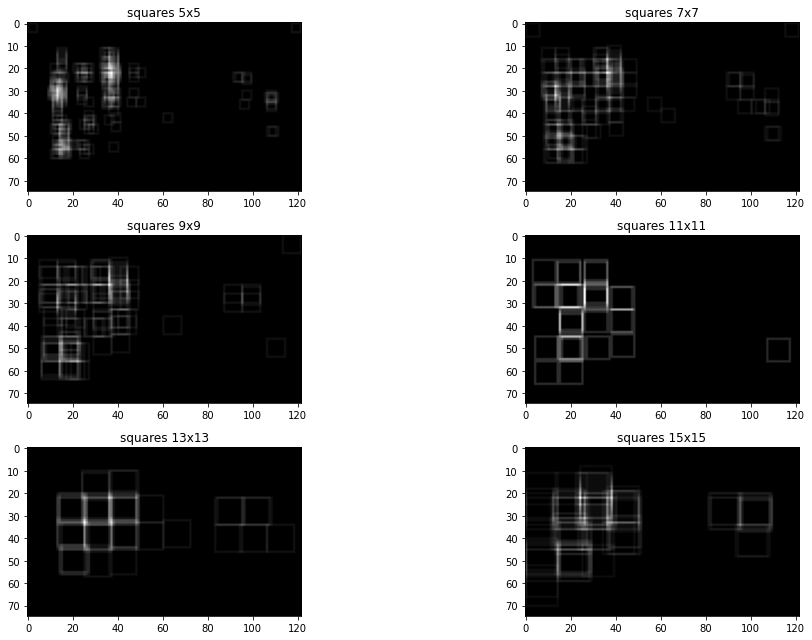

In [33]:
for i in range(filters):
    plt.subplot(3,2,i+1)
    plt.title("squares {size}x{size}".format(size=5+i*2))
    plt.imshow(hough_reverse_pipes_tensor[0, :, :, i], cmap='gray')
plt.tight_layout()
plt.show()

### Ninth layer - upscaling

#### Creating ninth layer 

In [34]:
upsample = tf.keras.layers.UpSampling2D(
    size=(8, 8), interpolation='nearest'
)

#### Ninth layer - output - the best image

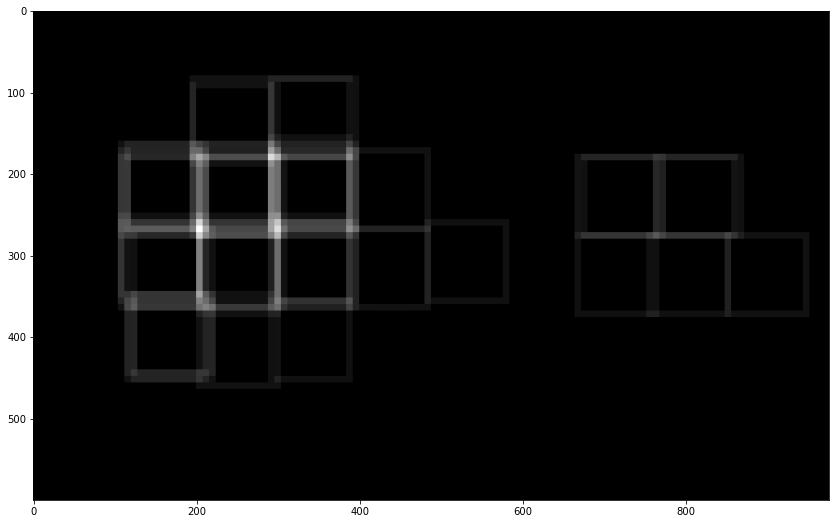

In [35]:
upscaled_tensor = upsample(hough_reverse_pipes_tensor)
best_image = upscaled_tensor[0, :, :, 4]
plt.imshow(best_image, cmap='gray')

### Final image

#### Merging base image and the best image from Hough transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


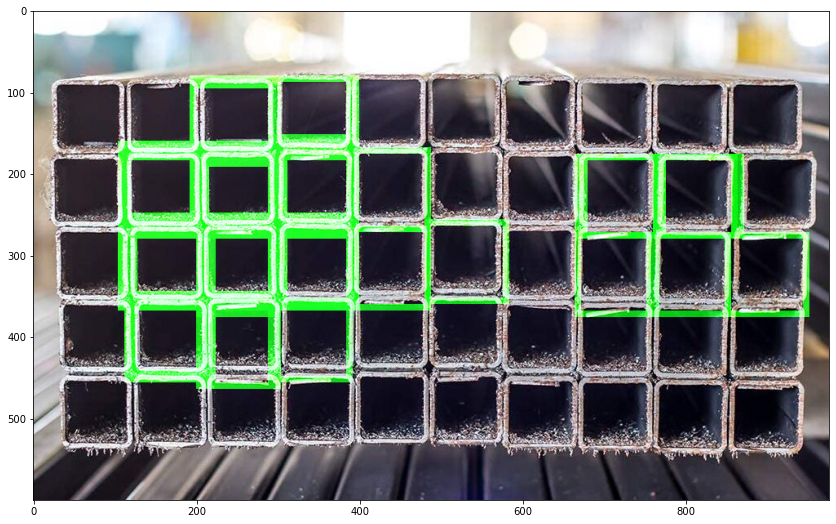

In [40]:
pipes_image_hough = np.copy(pipes_image)
print(type(pipes_image_hough))
pipes_image_hough[:, :, 1] = pipes_image_hough[:, :, 1] + best_image
plt.imshow(pipes_image_hough)
print(type(pipes_image_hough))

In [38]:
print(best_image.shape)

(600, 976)
